In [1]:
from math import *
import numpy as np
from scipy.linalg import lu_factor, lu_solve
import schemdraw
import schemdraw.elements as elm

Note that there are some machine epsilon errors in the below answers.
Node NNE1 : 7.23924706085133 V
Node ENE1 : 5.621260979165619 V
Node ESE1 : 4.311373805129236 V
Node SSE1 : 2.6803168606947687 V
Node SSW1 : 0.0 V
Node WSW1 : 3.529922939364123 V
Node WNW1 : 6.40271184493073 V
Node NNW1 : 5.341889242392688 V
Node NNE2 : 10.0 V
Node ENE2 : 4.953713345925412 V
Node ESE2 : 5.005063163866967 V
Node SSE2 : 4.953713345925412 V
Node SSW2 : 4.778836693215363 V
Node WSW2 : 4.95371334592541 V
Node WNW2 : 4.844191006959159 V
Node NNW2 : 4.953713345925412 V
Node CENTER : 4.953713345925412 V
Current between nodes NNE1 , ENE1 : 0.3235972163371422 amps
Current between nodes ENE1 , ESE1 : 0.26197743480727664 amps
Current between nodes ESE1 , SSE1 : 0.32621138888689344 amps
Current between nodes SSE1 , SSW1 : 0.5360633721389537 amps
Current between nodes SSW1 , WSW1 : -0.7059845878728246 amps
Current between nodes WSW1 , WNW1 : -0.5745577811133215 amps
Current between nodes WNW1 , NNW1 : -0.7194576310

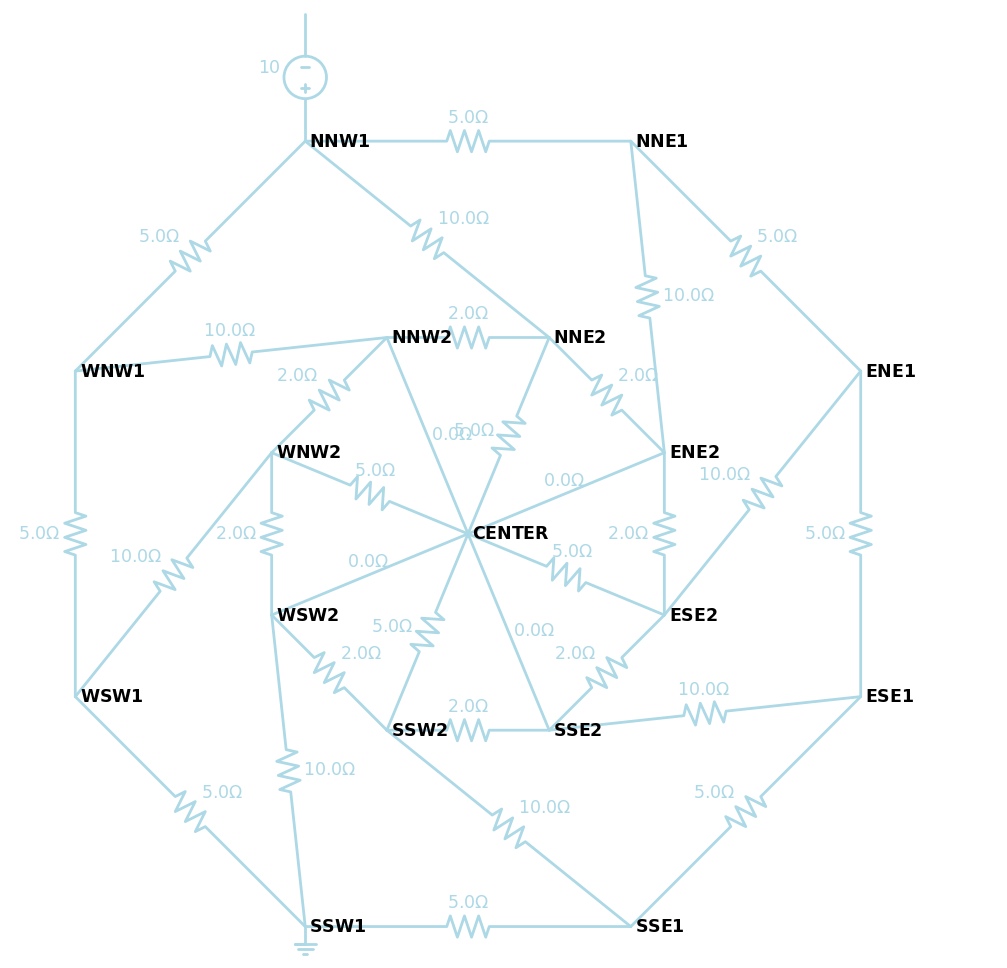

In [4]:
#this program takes a given text file (of certain specifications)
#and draws a circuit diagram 
#then solves for the voltages and currents in the specified circuit 

schematic = schemdraw.Drawing()

filename = "final.txt" #this is what changes based on text file
data = np.array(open(filename, "r").readlines())
num_nodes = int(data[0].replace("\n", ""))
coordinates = {}
names_index = {}
edges_index = {}

#create data dictionary and draw schematic labels
#create dictionary that corresponds to the reverse of the original dictionary
for i in range(1, num_nodes+1):
    name = data[i].split(" ")[0]
    x = float(data[i].split(" ")[1].replace("\n", ""))
    y = float(data[i].split(" ")[2].replace("\n", ""))
    coordinates.update({name: [i-1, x, y]}) #makes dictonary 
    names_index.update({i-1: name}) #makes reverse dictonary 
    schematic += elm.Line().endpoints((x, y), (x,y)).label('$\mathbf{' + name + "}$", loc = "right")
data = np.delete(data, np.arange(0, num_nodes + 1)) #delete data just iterated

num_edges = int(data[0].replace("\n", ""))

Amat = np.zeros((num_edges, num_nodes), dtype = float) #A matrix
Rmat = np.zeros((num_edges, num_edges), dtype = float) #R matrix

#create A matrix and draw schematic edges 
#A + R matrices go in the order listed on the text file
#creates data dictionary called "edges_index" that corresponds 
#to the row number in the matrix with the edges that row represents
for i in range(1, num_edges + 1): 
    edge_1 = data[i].split(" ")[0]
    edge_2 = data[i].split(" ")[1]
    omega = float(data[i].split(" ")[2])
    col1 = coordinates[edge_1][0]
    col2 = coordinates[edge_2][0]
    Amat[i-1][col1] = -1
    Amat[i-1][col2] = 1
    Rmat[i-1][i-1] = omega #creating the R matrix, which goes in the edge order listed on the text file
    edges_index.update({i - 1: [edge_1, edge_2]})
    if (omega == 0.0):
        schematic += elm.Line(color = 'lightblue').endpoints([coordinates[edge_1][1], coordinates[edge_1][2]], [coordinates[edge_2][1], coordinates[edge_2][2]]).label('$' + str(omega) + '\Omega$')
    else:
        schematic += elm.Resistor(color = 'lightblue').endpoints([coordinates[edge_1][1], coordinates[edge_1][2]], [coordinates[edge_2][1], coordinates[edge_2][2]]).label('$' + str(omega) + '\Omega$')
data = np.delete(data, np.arange(0, num_edges + 1)) #delete data just iterated

#find starting point, initial voltage, and end point 
source = data[0].split(" ")[0]
initial_v = data[0].split(" ")[1]
coordinates[source]
schematic += elm.SourceV(color = 'lightblue').endpoints((coordinates[source][1], coordinates[source][2]+3), (coordinates[source][1], coordinates[source][2])).label(initial_v) 
sink = data[1].replace("\n", "")
schematic += elm.Ground(color = 'lightblue').at((coordinates[sink][1], coordinates[sink][2]))

#delete columns from the A matrix that correspond to 
#the source and sink nodes
#this is because we know the voltage at these nodes
#so we can create a nonsingular matrix by performing some basic algebra
#and removing those columns from the matrix
col_to_delete = [coordinates[source][0], coordinates[sink][0]]
solve_amat = np.delete(Amat, col_to_delete, axis = 1)

#transpose of the smaller A matrix
solve_amatt = solve_amat.T
#the number of zeros we'll need in the bottom of the big matrix
zeros = np.zeros((solve_amat.shape[1], solve_amatt.shape[0]), dtype=float)
#making the entire matrix 
upper_row = np.concatenate((solve_amat, Rmat), axis = 1)
lower_row = np.concatenate((zeros, solve_amat.T), axis = 1)
#"combined" is the matrix we'll solve 
combined = np.concatenate((upper_row, lower_row), axis = 0)
#the source column that we delete * initial voltage (negative bc we subtract)
deleted_col = -float(initial_v)*Amat[:, coordinates[source][0]]

#figure out how many zeros I need to add onto the deleted column to perform subtraction
num_zeros = combined.shape[0] - deleted_col.shape[0]
extra_zeros = np.zeros((num_zeros), dtype = float) #create the extra zeros 
rhs = np.concatenate((deleted_col, extra_zeros)) #RHS = 0 vector - initial vector 

#use LU factorization to solve the matrix 
lu, piv = lu_factor(combined)
avec = lu_solve((lu, piv), rhs)

#modify the vector so it has all the voltages
modified_avec = np.insert(avec, coordinates[source][0], initial_v)
modified_avec = np.insert(modified_avec, coordinates[sink][0], 0)

print("Note that there are some machine epsilon errors in the below answers.")
for i in range(0,num_nodes):
    print("Node", names_index[i], ":", modified_avec[i], "V")
for i in range(0, num_edges):
    print("Current between nodes", edges_index[i][0], ",", edges_index[i][1], ":", modified_avec[i + num_nodes], "amps") 

schematic.draw()


